<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "VLMC"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/VLMC/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


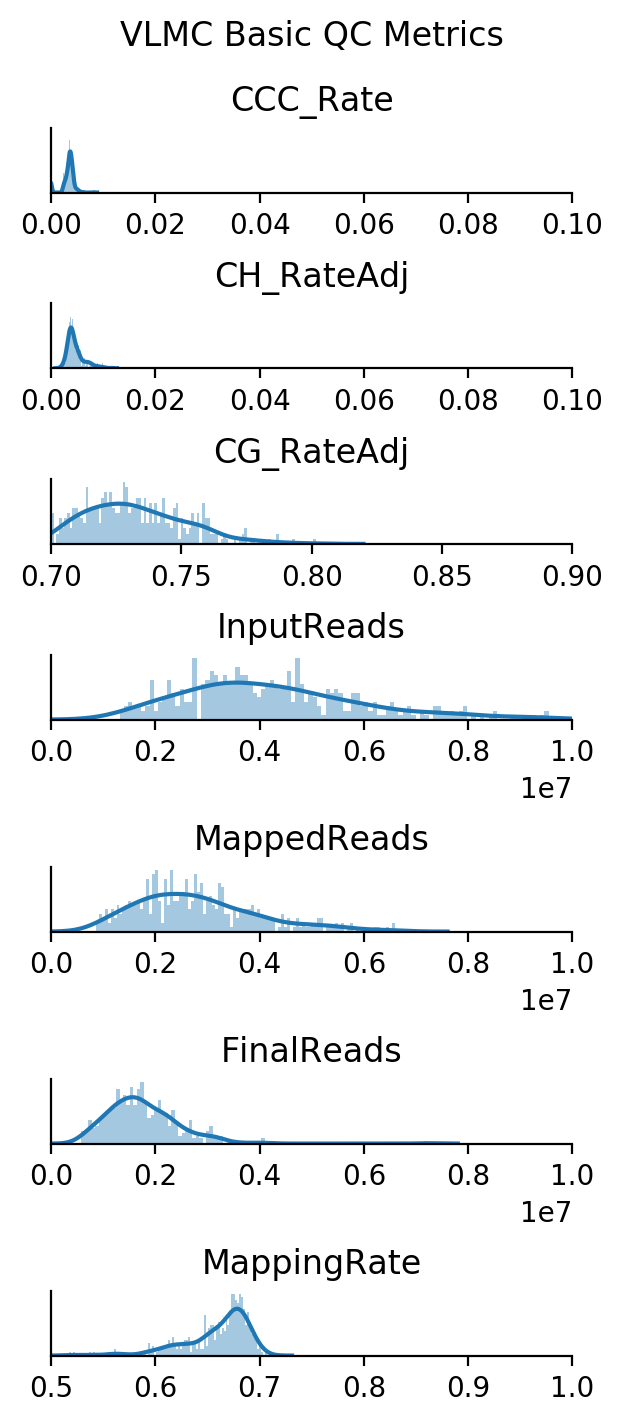

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

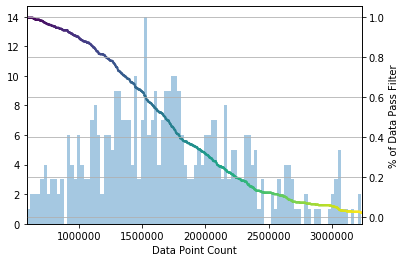

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 419/419 (100.0%)
CG_RateAdj passed 419/419 (100.0%)
CH_RateAdj passed 419/419 (100.0%)
FinalReads passed 419/419 (100.0%)
MappingRate passed 419/419 (100.0%)
Overall passed 419/419 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 7
171207 3
171212 1
171213 2
180104 5
180119 9
180122 2
180123 9
180205 5
180206 2
180208 1
180212 12
180213 4
180220 1
180222 3
180226 8
180227 19
180305 4
180306 3
180312 4
180313 4
180319 3
180320 8
180326 5
180329 9
180402 5
180403 9
180405 1
180409 10
180410 9
180412 6
180416 3
180417 2
180419 3
180423 4
180424 5
180426 1
180430 7
180501 2
180514 4
180529 3
180911 7
180917 1
180925 1
181002 8
181008 17
181009 16
181023 3
181204 4
181210 4
181220 1
190108 10
190117 12
190122 10
190124 4
190131 14
190205 27
190207 1
190212 3
190214 10
190219 12
190305 10
190307 8
190625 1
190627 1
190711 14
190716 13


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 57 14.8%
ad002 58 15.1%
ad004 62 16.1%
ad006 52 13.5%
ad007 59 15.4%
ad008 42 10.9%
ad010 51 13.3%
ad012 38 9.9%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_2177,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003548,0.735776,0.734835,0.007945,0.004413,1683613.0,4779752,3111483.0,10E,...,-23.803402,3.166746,-40.238474,23.003666,VLMC,9.410578,5.868047,-46.131429,2.015899,True
10E_M_700,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.004092,0.711247,0.710060,0.007988,0.003912,1136923.0,3108044,2027938.0,10E,...,-24.438467,4.206358,-40.123354,20.523199,VLMC,6.902449,6.130929,-51.502514,-3.744575,True
11E_M_1552,/gale/raidix/rdx-4/mapping/11E/CEMBA190305-11E...,0.003804,0.726100,0.725054,0.009532,0.005750,1754210.0,5134962,2871500.0,11E,...,-24.058313,2.843335,-40.901966,23.335556,VLMC,9.823119,5.566547,-44.116625,3.091927,True
11E_M_1640,/gale/raidix/rdx-4/mapping/11E/CEMBA190305-11E...,0.003471,0.710010,0.709000,0.008447,0.004993,1725304.0,4259548,2773818.0,11E,...,-24.271271,3.866202,-40.006669,21.484344,VLMC,8.243591,6.611290,-50.166393,-0.289551,True
11E_M_171,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.004734,0.764987,0.763870,0.012952,0.008258,1095529.0,2323150,1565844.0,11E,...,-23.824379,2.883096,-40.579390,23.476385,VLMC,9.687729,5.106700,-43.107611,2.841495,True
11F_M_1265,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.004020,0.720722,0.719595,0.007998,0.003995,1442146.0,3151596,2164367.0,11F,...,-24.262003,4.117272,-39.675538,21.089331,VLMC,7.454752,5.989827,-50.165300,-2.315745,True
11F_M_1269,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.003868,0.678112,0.676863,0.007353,0.003498,1288655.0,2924702,2003167.0,11F,...,-25.751476,3.675460,-44.090334,20.146929,VLMC,8.122081,7.730247,-53.566069,0.207337,True
11F_M_1361,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.004274,0.686863,0.685519,0.007646,0.003386,1749502.0,3958888,2704280.0,11F,...,-25.769213,4.163932,-43.794567,19.770377,VLMC,7.368769,7.034531,-52.829407,-1.897982,True
11F_M_1364,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.003977,0.697327,0.696119,0.007359,0.003396,1469456.0,3401930,2293379.0,11F,...,-24.882875,4.215238,-40.343180,20.390185,VLMC,7.322101,6.698692,-51.788710,-1.963404,True
